# MatchEd Analysis: Repeat Condition

This notebook examines data collected in condition ID 661e7c2853dca62a587e2488, which is the *repeat* condition intended to understand participant learning dynamics in repeated games. Uses some of the same code from the control analysis to read and transform data from MongoDB to CSV. Primary analysis includes rates of bias and truthful preference revelation as well as a comparison of those rates to the control condition.

## Processing and Basic Analysis

In [27]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import ast


In [10]:
# Read in the data
obj_id = "661e7c2853dca62a587e2488"
control_data = pd.read_csv(f'condition_{obj_id}.csv')
control_data.head()

,student_id,school_id,truthful_rank,payoff,submitted_rank,is_district
0,1,0,2,13,2.0,True
1,1,1,1,16,1.0,False
2,1,2,4,9,4.0,False
3,1,3,7,2,7.0,False
4,1,4,6,5,6.0,False


In [11]:
# We didn't get data for all students. Get a list of ids with data, meaning submitted ran is not null
ids_with_data = control_data[control_data['submitted_rank'].notnull()]['student_id'].unique()
control_data = control_data.loc[control_data['submitted_rank'].notnull()]
control_data['submitted_rank'] = control_data['submitted_rank'].astype(int)
print("We got data for", len(ids_with_data), "students with ids", ids_with_data)

We got data for 21 students with ids [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [12]:
control_data['correct'] = control_data['submitted_rank'] == control_data['truthful_rank']
# Group by student id and return number of students who got all correct
grouped_students = control_data.groupby('student_id')['correct'].sum()
correct_students = grouped_students[grouped_students == 7]
# Add a column to the dataframe to indicate if the student is correct
control_data['complete_truthtell'] = control_data['student_id'].isin(correct_students.index)
print("The number of students who ranked all preferences completely truthfully is", correct_students.shape[0], "out of", control_data['student_id'].nunique(), ". The ids are:", correct_students.index.values)

The number of students who ranked all preferences completely truthfully is 9 out of 21 . The ids are: [ 1  3  5 10 13 15 16 17 19]


In [13]:
groups = control_data.groupby('student_id')
count = 0
chen_sonmez_truthful = []
for _, group in groups:
    sorted_group = group.sort_values('truthful_rank')
    district_index = sorted_group[sorted_group['is_district']].index[0]

    # Check if series are equal up to and including the district index
    if (sorted_group.loc[:district_index, 'truthful_rank'] == sorted_group.loc[:district_index, 'submitted_rank']).all():
        chen_sonmez_truthful.append(group['student_id'].iloc[0])
        count += 1

# Print the result
print("Number of people with truthful_rank = submitted_rank up to and including the the district school:", count, "out of", control_data['student_id'].nunique(), ", yielding a percentage of", count/control_data['student_id'].nunique() * 100, "%", ". The ids are:", chen_sonmez_truthful)
control_data['partial_truthtell'] = control_data['student_id'].isin(chen_sonmez_truthful)
control_data.head(8)

Number of people with truthful_rank = submitted_rank up to and including the the district school: 12 out of 21 , yielding a percentage of 57.14285714285714 % . The ids are: [1, 2, 3, 5, 6, 7, 10, 13, 15, 16, 17, 19]


,student_id,school_id,truthful_rank,payoff,submitted_rank,is_district,correct,complete_truthtell,partial_truthtell
0,1,0,2,13,2,True,True,True,True
1,1,1,1,16,1,False,True,True,True
2,1,2,4,9,4,False,True,True,True
3,1,3,7,2,7,False,True,True,True
4,1,4,6,5,6,False,True,True,True
5,1,5,3,11,3,False,True,True,True
6,1,6,5,7,5,False,True,True,True
7,2,0,1,16,1,True,True,False,True


In [14]:
# Does having district school as top choice predict truthful preference revelation?
district_school_top_choice = []
for _, group in groups:
    district_index = group[group['is_district']].index[0]
    if group.loc[district_index, 'truthful_rank'] == 1:
        district_school_top_choice.append(group['student_id'].iloc[0])

print("Following student IDs had district school as their highest payoff school/truthful top choice:", district_school_top_choice, ". The subset that also ranked all preferences truthfully up to and including the district school is:", set(district_school_top_choice).intersection(set(chen_sonmez_truthful)))

# Respondent 5 didn't rank district school as top choice even though it had the highest payoff (quite counterintuitive)
groups.get_group(5).sort_values('truthful_rank')
    

Following student IDs had district school as their highest payoff school/truthful top choice: [2, 5] . The subset that also ranked all preferences truthfully up to and including the district school is: {2, 5}


,student_id,school_id,truthful_rank,payoff,submitted_rank,is_district,correct,complete_truthtell,partial_truthtell
29,5,1,1,16,1,True,True,True,True
32,5,4,2,13,2,False,True,True,True
28,5,0,3,11,3,False,True,True,True
34,5,6,4,9,4,False,True,True,True
33,5,5,5,7,5,False,True,True,True
31,5,3,6,5,6,False,True,True,True
30,5,2,7,2,7,False,True,True,True


In [15]:
# Recall that putting district school as higher choice means the submitted rank is better (ie. lower number) than the truthful rank
district_school_bias_index = []
small_school_bias_index = []
similar_preference_index = []
for i, group in groups:
    district_index = group[group['is_district']].index[0]
    # Check for district school bias
    if group.loc[district_index, 'truthful_rank'] > group.loc[district_index, 'submitted_rank']:
        district_school_bias_index.append(group['student_id'].iloc[0])

    # Check for small school bias by comparing truthful and submitted rank for school ids 0 and 1 (already sorted by school_id)
    first_row_idx = (i - 1) * group.shape[0]
    if group.loc[first_row_idx, 'truthful_rank'] < group.loc[first_row_idx, 'submitted_rank'] or group.loc[first_row_idx + 1, 'truthful_rank'] < group.loc[first_row_idx + 1, 'submitted_rank']:
        small_school_bias_index.append(group['student_id'].iloc[0])
    
    # Check for similar preferences bias (push highest payoff lower b/c fear of competition)
    group = group.sort_values('payoff', ascending=False)
    first_row = group.head(1)
    if first_row.iloc[0]['truthful_rank'] < first_row.iloc[0]['submitted_rank']:
        similar_preference_index.append(group['student_id'].iloc[0])

# Print results:
print("Following student IDs had district school bias:", district_school_bias_index)
print("Following student IDs had small school bias:", small_school_bias_index)
print("Following student IDs had similar preference bias:", similar_preference_index)
print("Following student IDs had partial truthful preference revelation:", chen_sonmez_truthful)

Following student IDs had district school bias: [4, 8, 9, 11, 14]
Following student IDs had small school bias: [4, 8, 9, 11, 12, 18, 21]
Following student IDs had similar preference bias: [4, 8, 9, 11, 12, 18, 21]
Following student IDs had partial truthful preference revelation: [1, 2, 3, 5, 6, 7, 10, 13, 15, 16, 17, 19]


In [16]:
# Add binary columns to the dataframe to indicate if the student has the respective bias
control_data['dsb'] = control_data['student_id'].isin(district_school_bias_index)
control_data['ssb'] = control_data['student_id'].isin(small_school_bias_index)
control_data['spb'] = control_data['student_id'].isin(similar_preference_index)
# Add columns for DsbSSb, DsbSPb, SsbSPb, DsbSSbSPb
control_data['DsbSSb'] = control_data['dsb'] & control_data['ssb'] & ~control_data['spb'] & ~control_data['partial_truthtell']
control_data['DsbSPb'] = control_data['dsb'] & control_data['spb'] & ~control_data['ssb'] & ~control_data['partial_truthtell']
control_data['SsbSPb'] = control_data['ssb'] & control_data['spb'] & ~control_data['dsb'] & ~control_data['partial_truthtell']
control_data['DsbSSbSPb'] = control_data['dsb'] & control_data['ssb'] & control_data['spb'] & ~control_data['partial_truthtell']
control_data['DsbOnly'] = control_data['dsb'] & ~control_data['ssb'] & ~control_data['spb'] & ~control_data['partial_truthtell']
control_data['SsbOnly'] = control_data['ssb'] & ~control_data['dsb'] & ~control_data['spb'] & ~control_data['partial_truthtell']
control_data['SpbOnly'] = control_data['spb'] & ~control_data['dsb'] & ~control_data['ssb'] & ~control_data['partial_truthtell']
control_data.head(8)

,student_id,school_id,truthful_rank,payoff,submitted_rank,is_district,correct,complete_truthtell,partial_truthtell,dsb,ssb,spb,DsbSSb,DsbSPb,SsbSPb,DsbSSbSPb,DsbOnly,SsbOnly,SpbOnly
0,1,0,2,13,2,True,True,True,True,False,False,False,False,False,False,False,False,False,False
1,1,1,1,16,1,False,True,True,True,False,False,False,False,False,False,False,False,False,False
2,1,2,4,9,4,False,True,True,True,False,False,False,False,False,False,False,False,False,False
3,1,3,7,2,7,False,True,True,True,False,False,False,False,False,False,False,False,False,False
4,1,4,6,5,6,False,True,True,True,False,False,False,False,False,False,False,False,False,False
5,1,5,3,11,3,False,True,True,True,False,False,False,False,False,False,False,False,False,False
6,1,6,5,7,5,False,True,True,True,False,False,False,False,False,False,False,False,False,False
7,2,0,1,16,1,True,True,False,True,False,False,False,False,False,False,False,False,False,False


In [42]:
# Store intermediate results, collapsing the dataframe to one row per student to make for easier analysis by pivoting
new_data = control_data.groupby('student_id').agg({
    'complete_truthtell': 'first',
    'partial_truthtell': 'first',
    'dsb': 'first',
    'ssb': 'first',
    'spb': 'first',
    'DsbSSb': 'first',
    'DsbSPb': 'first',
    'SsbSPb': 'first',
    'DsbSSbSPb': 'first',
    'DsbOnly': 'first',
    'SsbOnly': 'first',
    'SpbOnly': 'first'
}).reset_index()
print(len(control_data[control_data['truthful_rank'] == 6].groupby('student_id')['school_id'].first().values))
# Append 7 columns for r1-r7, indicating the school ID for each of the 7 submitted rankings
for i in range(1, 8):
    new_data[f'r{i}'] = control_data[control_data['submitted_rank'] == i].groupby('student_id')['school_id'].first().values

# Append 7 columns for t1-t7, indicating the school ID for each of the 7 truthful rankings
for i in range(1, 8):
    new_data[f't{i}'] = control_data[control_data['truthful_rank'] == i].groupby('student_id')['school_id'].first().values

# Append 7 columns for p1-p7, indicating the payoff for each of the school Ids 0 to 6
for i in range(7):
    new_data[f'p{i}'] = control_data[control_data['school_id'] == i].groupby('student_id')['payoff'].first().values


# Add column for the id of the district school
new_data['district_school'] = control_data[control_data['is_district']].groupby('student_id')['school_id'].first().values

new_data.tail(8)


21


,student_id,complete_truthtell,partial_truthtell,dsb,ssb,spb,DsbSSb,DsbSPb,SsbSPb,DsbSSbSPb,...,t6,t7,p0,p1,p2,p3,p4,p5,p6,district_school
13,14,False,False,True,False,False,False,False,False,False,...,1,2,16,5,2,9,7,13,11,3
14,15,True,True,False,False,False,False,False,False,False,...,6,4,13,16,9,11,2,7,5,3
15,16,True,True,False,False,False,False,False,False,False,...,3,6,16,13,11,5,9,7,2,3
16,17,True,True,False,False,False,False,False,False,False,...,2,4,13,16,5,7,2,9,11,3
17,18,False,False,False,True,True,False,False,True,False,...,2,6,16,13,5,9,7,11,2,3
18,19,True,True,False,False,False,False,False,False,False,...,3,6,11,16,7,5,13,9,2,4
19,20,False,False,False,False,False,False,False,False,False,...,4,5,16,13,7,9,5,2,11,4
20,21,False,False,False,True,True,False,False,True,False,...,6,2,13,16,2,7,9,11,5,4


In [18]:
# Store the final results
new_data.to_csv(f'repeat_processed.csv', index=False)

In [19]:
# Output a table with the proportions of truthful preference revelation and misrepresentation. 
# We first need to make sure each student is only counted once, but this should've been accomplished by construction
cols = ["partial_truthtell", "DsbOnly", "DsbSSb", "DsbSPb", "SsbSPb", "SsbOnly", "SpbOnly", "DsbSSbSPb"]
truthtelling_proportions = new_data[cols].mean()

# Find any IDs not accounted for
all_ids = set(new_data['student_id'].values)
no_bias_not_truthful = new_data[(new_data['dsb'] == 0) & (new_data['ssb'] == 0) & (new_data['spb'] == 0) & (new_data['partial_truthtell'] == 0)]['student_id'].values
print("IDs not accounted for:", no_bias_not_truthful)

truthtelling_proportions["Other"] = len(no_bias_not_truthful) / new_data.shape[0]
print(truthtelling_proportions, "Sum:", truthtelling_proportions.sum())
assert truthtelling_proportions.sum() == 1

IDs not accounted for: [20]
partial_truthtell    0.571429
DsbOnly              0.047619
DsbSSb               0.000000
DsbSPb               0.000000
SsbSPb               0.142857
SsbOnly              0.000000
SpbOnly              0.000000
DsbSSbSPb            0.190476
Other                0.047619
dtype: float64 Sum: 1.0


In [20]:
# Export to LaTeX file with labels and proportions
truthtelling_proportions = truthtelling_proportions.reset_index()
truthtelling_proportions.columns = ['Bias', 'Proportion']
latex_table = truthtelling_proportions.to_latex(index=False, column_format='p{3cm}p{7cm}')
with open('latex/repeat_truthtelling_proportions.tex', 'w') as f:
    f.write(latex_table)


We want to do a simple t-test of equality of two proportions, comparing the rates of truthtelling in the control to the repeat condition.

In [21]:
from scipy import stats

In [22]:
p_control = 0.357
p_repeat = 0.57143

n_control = 28
n_repeat = 21

control_sample_variance = p_control * (1 - p_control)
repeat_sample_variance = p_repeat * (1 - p_repeat)

test_statistic, p_value = stats.ttest_ind_from_stats(mean1=p_control, std1=np.sqrt(control_sample_variance), nobs1=n_control, mean2=p_repeat, std2=np.sqrt(repeat_sample_variance), nobs2=n_repeat)
print(test_statistic)
print(p_value)

-1.528780587198309
0.1330217689556797


We want to look at the proportion of truthtellers across each of the 5 practice rounds. Rather than storing all 7 rankings for each of the 5 practice rounds (35 total rankings per participant), we will create five new columns: `practice_1_truthful` through `practice_5_truthful`, which is just a boolean variable indicating whether the student reported truthfully in that period.

In [34]:
new_data.head()

,student_id,complete_truthtell,partial_truthtell,dsb,ssb,spb,DsbSSb,DsbSPb,SsbSPb,DsbSSbSPb,...,t6,t7,p0,p1,p2,p3,p4,p5,p6,district_school
0,1,True,True,False,False,False,False,False,False,False,...,4,3,13,16,9,2,5,11,7,0
1,2,False,True,False,False,False,False,False,False,False,...,5,4,16,13,11,7,2,5,9,0
2,3,True,True,False,False,False,False,False,False,False,...,6,4,11,13,7,16,2,9,5,0
3,4,False,False,True,True,True,False,False,False,True,...,3,4,16,13,11,5,2,7,9,1
4,5,True,True,False,False,False,False,False,False,False,...,3,2,11,16,2,5,13,7,9,1


Recall that we only look at behavior up to the district school, so we need to account for that in code.

In [35]:
obj_id = "661e7c2853dca62a587e2488"
practice_data = pd.read_csv(f'practice_data_{obj_id}.csv')
practice_data.head()

,student_id,submitted_order,practice_1,practice_2,practice_3,practice_4,practice_5,truthful_rankings,practice_1_truth,practice_2_truth,practice_3_truth,practice_4_truth,practice_5_truth,submitted_truth
0,1,"[2, 1, 4, 7, 6, 3, 5]","[1, 2, 4, 7, 6, 3, 5]","[2, 1, 4, 7, 6, 3, 5]","[2, 1, 4, 7, 6, 3, 5]","[2, 1, 4, 7, 6, 3, 5]","[2, 1, 4, 7, 6, 3, 5]","[2, 1, 4, 7, 6, 3, 5]",False,True,True,True,True,True
1,2,"[1, 2, 4, 5, 7, 6, 3]","[1, 2, 3, 5, 6, 7, 4]","[1, 2, 3, 5, 6, 7, 4]","[1, 2, 3, 5, 6, 7, 4]","[1, 2, 3, 5, 6, 7, 4]","[1, 2, 3, 5, 6, 7, 4]","[1, 2, 3, 5, 7, 6, 4]",False,False,False,False,False,False
2,3,"[3, 2, 5, 1, 7, 4, 6]","[2, 3, 5, 1, 7, 4, 6]","[2, 3, 5, 1, 7, 4, 6]","[2, 3, 5, 1, 7, 4, 6]","[2, 3, 5, 1, 7, 4, 6]","[2, 3, 5, 1, 7, 4, 6]","[3, 2, 5, 1, 7, 4, 6]",False,False,False,False,False,True
3,4,"[2, 1, 3, 6, 7, 5, 4]","[2, 1, 3, 6, 7, 5, 4]","[2, 1, 3, 6, 7, 5, 4]","[2, 1, 3, 6, 7, 5, 4]","[2, 1, 3, 6, 7, 5, 4]","[2, 1, 3, 6, 7, 5, 4]","[1, 2, 3, 6, 7, 5, 4]",False,False,False,False,False,False
4,5,"[3, 1, 7, 6, 2, 5, 4]","[3, 1, 7, 6, 2, 5, 4]","[3, 1, 7, 6, 2, 5, 4]","[3, 1, 7, 6, 2, 5, 4]","[3, 1, 7, 6, 2, 5, 4]","[3, 1, 7, 6, 2, 5, 4]","[3, 1, 7, 6, 2, 5, 4]",True,True,True,True,True,True


In [36]:
# Join to previous data frame
merged_df = pd.merge(new_data, practice_data, on='student_id', suffixes=('_left', '_right'), how='inner')
print(merged_df.columns)
merged_df.head(1)

Index(['student_id', 'complete_truthtell', 'partial_truthtell', 'dsb', 'ssb',
       'spb', 'DsbSSb', 'DsbSPb', 'SsbSPb', 'DsbSSbSPb', 'DsbOnly', 'SsbOnly',
       'SpbOnly', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 't1', 't2', 't3',
       't4', 't5', 't6', 't7', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6',
       'district_school', 'submitted_order', 'practice_1', 'practice_2',
       'practice_3', 'practice_4', 'practice_5', 'truthful_rankings',
       'practice_1_truth', 'practice_2_truth', 'practice_3_truth',
       'practice_4_truth', 'practice_5_truth', 'submitted_truth'],
      dtype='object')


,student_id,complete_truthtell,partial_truthtell,dsb,ssb,spb,DsbSSb,DsbSPb,SsbSPb,DsbSSbSPb,...,practice_3,practice_4,practice_5,truthful_rankings,practice_1_truth,practice_2_truth,practice_3_truth,practice_4_truth,practice_5_truth,submitted_truth
0,1,True,True,False,False,False,False,False,False,False,...,"[2, 1, 4, 7, 6, 3, 5]","[2, 1, 4, 7, 6, 3, 5]","[2, 1, 4, 7, 6, 3, 5]","[2, 1, 4, 7, 6, 3, 5]",False,True,True,True,True,True


In [37]:
# Convert string representations of arrays back to lists
merged_df['submitted_order'] = merged_df['submitted_order'].apply(lambda x: ast.literal_eval(x))
merged_df['truthful_rankings'] = merged_df['truthful_rankings'].apply(lambda x: ast.literal_eval(x))
merged_df['practice_1'] = merged_df['practice_1'].apply(lambda x: ast.literal_eval(x))
merged_df['practice_2'] = merged_df['practice_2'].apply(lambda x: ast.literal_eval(x))
merged_df['practice_3'] = merged_df['practice_3'].apply(lambda x: ast.literal_eval(x))
merged_df['practice_4'] = merged_df['practice_4'].apply(lambda x: ast.literal_eval(x))
merged_df['practice_5'] = merged_df['practice_5'].apply(lambda x: ast.literal_eval(x))
merged_df.head(1)


,student_id,complete_truthtell,partial_truthtell,dsb,ssb,spb,DsbSSb,DsbSPb,SsbSPb,DsbSSbSPb,...,practice_3,practice_4,practice_5,truthful_rankings,practice_1_truth,practice_2_truth,practice_3_truth,practice_4_truth,practice_5_truth,submitted_truth
0,1,True,True,False,False,False,False,False,False,False,...,"[2, 1, 4, 7, 6, 3, 5]","[2, 1, 4, 7, 6, 3, 5]","[2, 1, 4, 7, 6, 3, 5]","[2, 1, 4, 7, 6, 3, 5]",False,True,True,True,True,True


In [58]:
def compare_lists(row, column_name):
    index_to_compare = row['district_school'] + 1
    return row[column_name][:index_to_compare] == row['truthful_rankings'][:index_to_compare]

merged_df['practice_1_truth'] = merged_df.apply(lambda row: compare_lists(row, "practice_1"), axis=1)
merged_df['practice_2_truth'] = merged_df.apply(lambda row: compare_lists(row, "practice_2"), axis=1)
merged_df['practice_3_truth'] = merged_df.apply(lambda row: compare_lists(row, "practice_3"), axis=1)
merged_df['practice_4_truth'] = merged_df.apply(lambda row: compare_lists(row, "practice_4"), axis=1)
merged_df['practice_5_truth'] = merged_df.apply(lambda row: compare_lists(row, "practice_5"), axis=1)
merged_df['submitted_truth'] = merged_df.apply(lambda row: compare_lists(row, "submitted_order"), axis=1)
merged_df.head()


,student_id,complete_truthtell,partial_truthtell,dsb,ssb,spb,DsbSSb,DsbSPb,SsbSPb,DsbSSbSPb,...,practice_4,practice_5,truthful_rankings,practice_1_truth,practice_2_truth,practice_3_truth,practice_4_truth,practice_5_truth,submitted_truth,submitted
0,1,True,True,False,False,False,False,False,False,False,...,"[2, 1, 4, 7, 6, 3, 5]","[2, 1, 4, 7, 6, 3, 5]","[2, 1, 4, 7, 6, 3, 5]",False,True,True,True,True,True,True
1,2,False,True,False,False,False,False,False,False,False,...,"[1, 2, 3, 5, 6, 7, 4]","[1, 2, 3, 5, 6, 7, 4]","[1, 2, 3, 5, 7, 6, 4]",True,True,True,True,True,True,True
2,3,True,True,False,False,False,False,False,False,False,...,"[2, 3, 5, 1, 7, 4, 6]","[2, 3, 5, 1, 7, 4, 6]","[3, 2, 5, 1, 7, 4, 6]",False,False,False,False,False,True,True
3,4,False,False,True,True,True,False,False,False,True,...,"[2, 1, 3, 6, 7, 5, 4]","[2, 1, 3, 6, 7, 5, 4]","[1, 2, 3, 6, 7, 5, 4]",False,False,False,False,False,False,False
4,5,True,True,False,False,False,False,False,False,False,...,"[3, 1, 7, 6, 2, 5, 4]","[3, 1, 7, 6, 2, 5, 4]","[3, 1, 7, 6, 2, 5, 4]",True,True,True,True,True,True,True


Let's do some subsetting of the columns so we only have what we want. This will reduce some of the noise.

In [59]:
merged_df.iloc[1]

student_id                                2
complete_truthtell                    False
partial_truthtell                      True
dsb                                   False
ssb                                   False
spb                                   False
DsbSSb                                False
DsbSPb                                False
SsbSPb                                False
DsbSSbSPb                             False
DsbOnly                               False
SsbOnly                               False
SpbOnly                               False
r1                                        0
r2                                        1
r3                                        6
r4                                        2
r5                                        3
r6                                        5
r7                                        4
t1                                        0
t2                                        1
t3                              

In [64]:
columns = ['practice_1_truth', 'practice_2_truth', 'practice_3_truth', 'practice_4_truth', 'practice_5_truth', 'submitted_truth']
small_practice_data = merged_df[columns].copy()

In [65]:
# Truthful IDs:  The ids are: [1, 2, 3, 5, 6, 7, 10, 13, 15, 16, 17, 19]
small_practice_data.head()


,practice_1_truth,practice_2_truth,practice_3_truth,practice_4_truth,practice_5_truth,submitted_truth
0,False,True,True,True,True,True
1,True,True,True,True,True,True
2,False,False,False,False,False,True
3,False,False,False,False,False,False
4,True,True,True,True,True,True


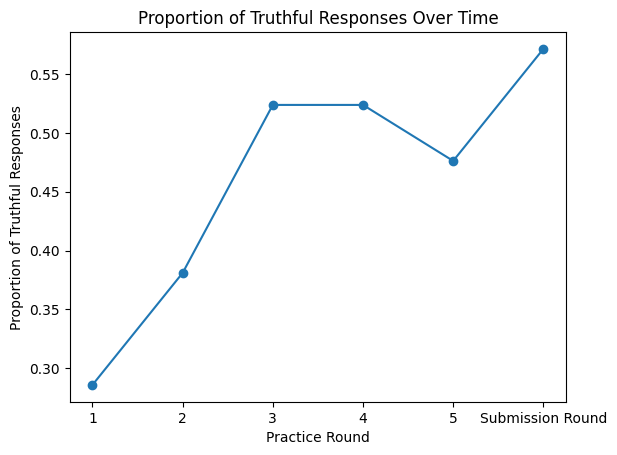

In [68]:
small_practice_data.columns = ['1', '2', '3', '4', '5', '6']
# Calculate proportions of true values
proportions = small_practice_data.mean()

# Plot
plt.plot(range(1, 7), proportions, marker='o', linestyle='-')
plt.xlabel('Practice Round')
plt.ylabel('Proportion of Truthful Responses')
plt.title('Proportion of Truthful Responses Over Time')
plt.xticks(range(1, 7), ['1', '2', '3', '4', '5', 'Submission Round'])
plt.show()

In [67]:
proportions

1    0.285714
2    0.380952
3    0.523810
4    0.523810
5    0.476190
6    0.571429
dtype: float64

In [69]:
p_control = 0.29
p_repeat = 0.57143

n_control = 21
n_repeat = 21

control_sample_variance = p_control * (1 - p_control)
repeat_sample_variance = p_repeat * (1 - p_repeat)

test_statistic, p_value = stats.ttest_ind_from_stats(mean1=p_control, std1=np.sqrt(control_sample_variance), nobs1=n_control, mean2=p_repeat, std2=np.sqrt(repeat_sample_variance), nobs2=n_repeat)
print(test_statistic)
print(p_value)

-1.920831042457005
0.06190095189977185
